<a href="https://colab.research.google.com/github/your-repo/Lab_QEC_Quantum_Error_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [11]:
%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

# Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# QuTiP imports
import qutip as qt
from qutip import *

# QUTIP QIP
from qutip.qip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate
from qutip_qip.qasm import circuit_to_qasm_str

# Qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector

'''In Jupyter Notebooks we can display this nicely using LaTeX.'''
from qiskit.visualization import array_to_latex

In [12]:
'''https://github.com/qiskit-community/qiskit-ignis/blob/stable/0.3/qiskit/ignis/verification/tomography/data.py'''
# Needed for functions
from itertools import combinations
from functools import reduce
from re import match
from typing import Dict, Union, List

def combine_counts(counts1: Dict[str, int],
                   counts2: Dict[str, int]
                   ) -> Dict[str, int]:
    """Combine two counts dictionaries.
    Args:
        counts1: One of the count dictionaries to combine.
        counts2: One of the count dictionaries to combine.
    Returns:
        A dict containing the **sum** of entries in counts1 and counts2
        where a nonexisting entry is treated as 0
    Example:
        >>> counts1 = {'00': 3, '01': 5}
        >>> counts2 = {'00': 4, '10': 7}
        >>> combine_counts(counts1, counts2)
        {'00': 7, '01': 5, '10': 7}
    """
    ret = counts1
    for key, val in counts2.items():
        if key in ret:
            ret[key] += val
        else:
            ret[key] = val
    return ret

## Quantum Error Correction

Quantum systems are inherently fragile and susceptible to errors from environmental interactions. This lab introduces the fundamental concepts of quantum error correction (QEC) and demonstrates how we can protect quantum information using redundancy and syndrome measurements.

### Objectives
1. Understand different types of quantum errors
2. Implement basic quantum error correction codes
3. Perform syndrome measurements
4. Analyze the effectiveness of error correction strategies

### References
- Nielsen & Chuang: Chapter 10 (Quantum Error Correction)
- [IBM Quantum Error Correction Tutorial](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html)
- https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction/correcting-quantum-errors

## Part 1: Quantum Errors

Unlike classical bits which only experience bit flips (0→1 or 1→0), quantum bits can experience:

1. **Bit Flip Errors**: |0⟩ ↔ |1⟩ (X gate)
2. **Phase Flip Errors**: |+⟩ ↔ |-⟩ (Z gate)
3. **Combined Errors**: Both bit and phase flips (Y gate)
4. **Decoherence**: Loss of quantum information to the environment

Let's start by simulating these errors on a single qubit.

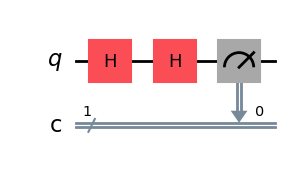

In [30]:
QasmSim = QasmSimulator() #Set simulator to evolve state

def apply_random_error(qc, qubit_idx, p_x, p_z):
    """Apply random X or Z error with given probabilities
    
    Args:
        qc (QuantumCircuit): Circuit to apply error to
        qubit_idx (int): Index of qubit to apply error
        p_x (float): Probability of X error
        p_z (float): Probability of Z error
    """
    r = np.random.random()
    if r < p_x:
        qc.x(qubit_idx)  # Bit flip
    elif r < p_x + p_z:
        qc.z(qubit_idx)  # Phase flip

def single_qubit_error_demo( p_error=0.2):
    """Demonstrate errors on a single qubit"""
    qc = QuantumCircuit(1, 1)
    qc.h(0)    # Prepare |+⟩ state
    # Apply random error
    apply_random_error(qc, 0, p_x=p_error, p_z=p_error)
    qc.h(0)
    qc.measure(0, 0)

    job = QasmSim.run(qc, shots=1)
    result = job.result()
    count = result.get_counts()
    return count

'''Quick example with random error'''
p_error = 0.2

qc = QuantumCircuit(1, 1)

qc.h(0)# Prepare |+⟩ state

apply_random_error(qc, 0, p_x=p_error, p_z=p_error) # Apply random error

qc.h(0)

qc.measure(0, 0)

qc.draw('mpl')

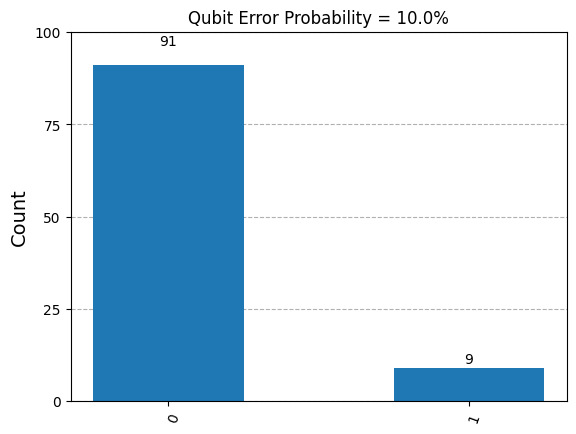

In [49]:
'''Run simulation many times with random errors each instance'''

nshots = 100
shots = arange(nshots)

p_error = 0.1

counts = {}
for shot in shots: 
    counts = combine_counts(counts, single_qubit_error_demo(p_error=p_error))

plot_histogram(counts, title=('Qubit Error Probability = ' + str(p_error*100) + '%') , sort='asc')

### Exercise 1.1: Error Analysis

1. Run the above simulation multiple times with different error probabilities.
2. How do the measurement statistics change as you vary p_x and p_z?
3. What happens when you prepare different initial states?

## Part 2: The 3-Qubit Bit Flip Code

The simplest quantum error correction code protects against bit flip errors by encoding:
- $|0⟩ → |000⟩$
- $|1⟩ → |111⟩$

This encoding allows us to detect and correct single bit flip errors through majority voting.

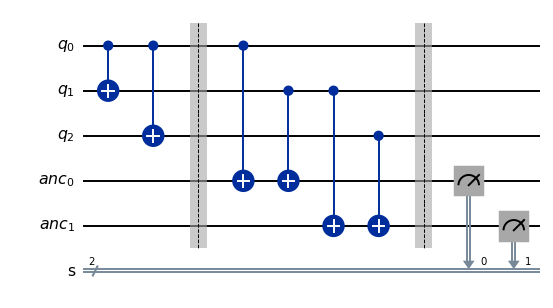

In [79]:
def create_3qubit_code():
    """Create a circuit implementing the 3-qubit bit flip code"""
    # Create registers
    qr = QuantumRegister(3, 'q')
    # cr = ClassicalRegister(3, 'c')
    anc = QuantumRegister(2, 'anc')  # Ancilla qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 's')
    qc = QuantumCircuit(qr, anc, syndrome)
    
    # Encoding
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)
    
    # Add barrier to separate encoding
    qc.barrier()
    
    return qc

def add_syndrome_measurement(qc):
    """Add syndrome measurement circuit"""
    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    qc.barrier()

    # Measure ancillas
    qc.measure([3,4], [0,1])
    return qc

qc = create_3qubit_code()
qc = add_syndrome_measurement(qc)
qc.draw('mpl', scale=0.7)

### Exercise 2.1: Syndrome Measurements

The syndrome measurements tell us which qubit (if any) experienced a bit flip:

| Syndrome | Error Location |
|----------|----------------|
| 00       | No error      |
| 01       | Error on q2   |
| 10       | Error on q1   |
| 11       | Error on q0   |

Complete the following tasks:
1. Add random bit flip errors to the circuit
2. Interpret the syndrome measurements
3. Apply correction based on syndrome results

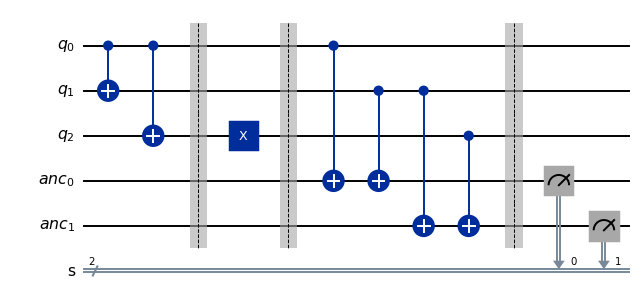

In [80]:
p_error = 0.3
# Create circuit
qc = create_3qubit_code()

# Add random bit flip errors
for i in range(3):
    if np.random.random() < p_error:
        qc.x(i)

qc.barrier()

# Add syndrome measurement
qc = add_syndrome_measurement(qc)

qc.draw('mpl', scale=0.7)

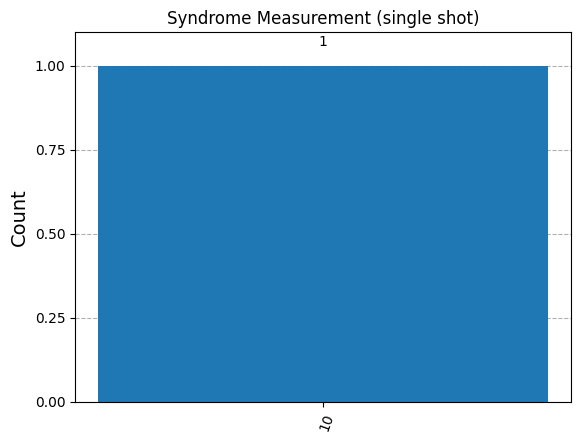

In [82]:
job = QasmSim.run(qc, shots=1)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, title='Syndrome Measurement (single shot)' , sort='asc')

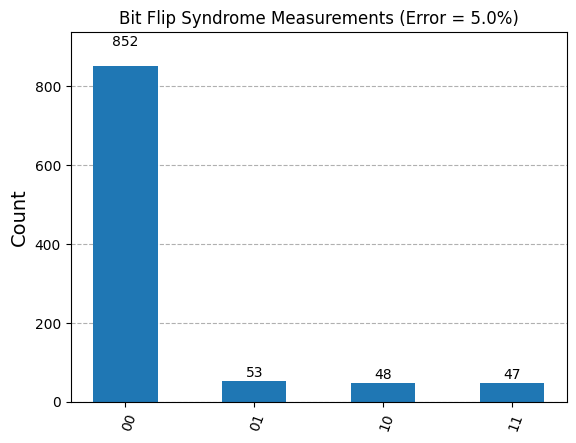

In [83]:
def run_error_correction(initial_state=0, p_error=0.2):
    """Run full error correction protocol
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_error (float): Probability of bit flip on each qubit
        n_shots (int): Number of circuit executions
    """
    # Create circuit
    qc = create_3qubit_code()
    
    # Initialize if needed
    if initial_state == 1:
        qc.x(0)
    
    # Add random errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.x(i)
    
    # Add syndrome measurement
    qc = add_syndrome_measurement(qc)
    
    # Execute
    job = QasmSim.run(qc, shots=1)

    result = job.result()
    counts = result.get_counts()
    
    return counts

# Run Simulation with errors and display Syndrome measurements

p_error=1-0.95

nshots = 1000
shots = arange(nshots)

counts = {}
for shot in shots: 
    counts = combine_counts(counts, run_error_correction(p_error=p_error))

plot_histogram(counts, title=('Bit Flip Syndrome Measurements (Error = ' + str(round(p_error*100,2)) + '%)') , sort='asc')

### Phase flip errors?

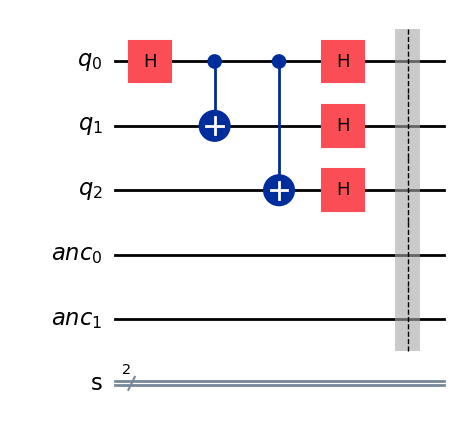

In [128]:
def create_3qubit_phase_code():
    """Create a circuit implementing the 3-qubit phase flip code"""
    # Create registers
    qr = QuantumRegister(3, 'q')
    # cr = ClassicalRegister(3, 'c')
    anc = QuantumRegister(2, 'anc')  # Ancilla qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 's')
    qc = QuantumCircuit(qr, anc, syndrome)
    
    # Encoding
    qc.h(0)
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)

    for qubit in range(0,3):
        qc.h(qubit)
    
    # Add barrier to separate encoding
    qc.barrier()
    
    return qc

qc = create_3qubit_phase_code()

qc.draw('mpl')

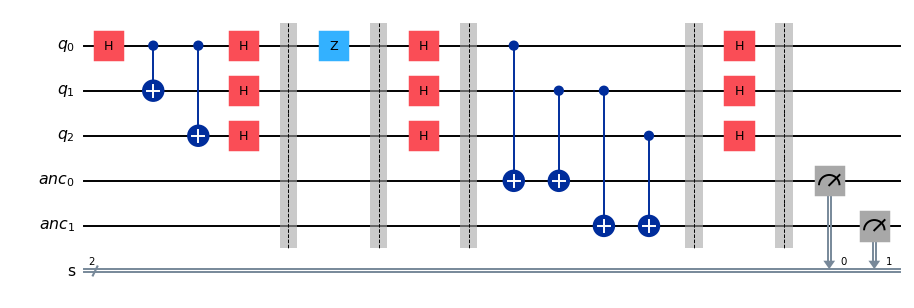

In [148]:
def add_phase_syndrome_measurement(qc):
    """Add Phase syndrome measurement circuit"""

    for qubit in range(0,3):
        qc.h(qubit)

    qc.barrier()

    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    qc.barrier()


    for qubit in range(0,3):
        qc.h(qubit)

    qc.barrier()

    # Measure ancillas
    qc.measure([3,4], [0,1])
    return qc


p_error = 0.3
# Create circuit
qc = create_3qubit_phase_code()

# Add random phase flip errors
for i in range(3):
    if np.random.random() < p_error:
        qc.z(i)

qc.barrier()

# Add syndrome measurement
qc = add_phase_syndrome_measurement(qc)

qc.draw('mpl', scale=0.7)

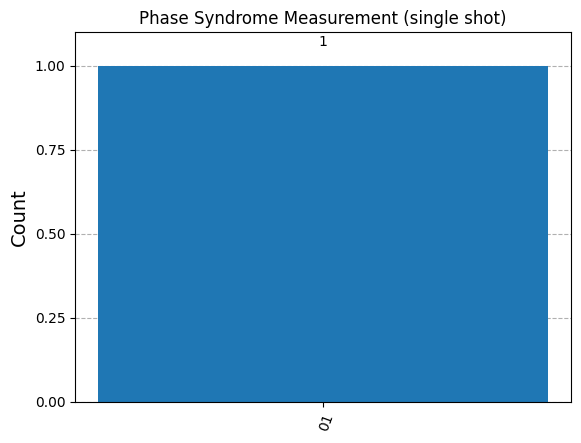

In [149]:
job = QasmSim.run(qc, shots=1)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, title='Phase Syndrome Measurement (single shot)' , sort='asc')

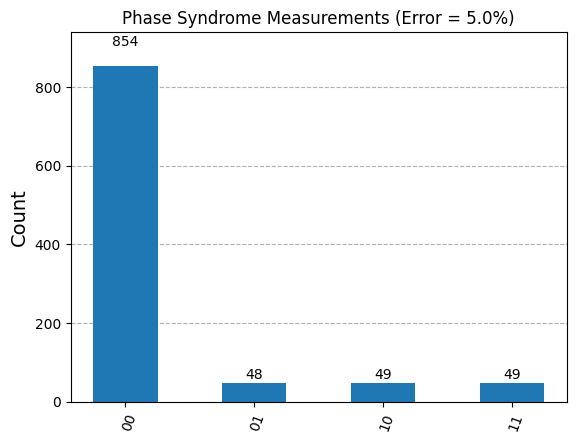

In [151]:
def run_error_correction(initial_state=0, p_error=0.2):
    """Run full error correction protocol
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_error (float): Probability of bit flip on each qubit
        n_shots (int): Number of circuit executions
    """
    if initial_state == 1:
        qc.x(0)    
        
    qc = create_3qubit_phase_code()

    '''Add random phase flip errors'''
    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i)

    qc.barrier()

    '''Add phase syndrome measurement'''
    qc = add_phase_syndrome_measurement(qc)
    
    job = QasmSim.run(qc, shots=1)

    result = job.result()
    counts = result.get_counts()
    
    return counts

# Run Simulation with errors and display Syndrome measurements

p_error=1-0.95

nshots = 1000
shots = arange(nshots)

counts = {}
for shot in shots: 
    counts = combine_counts(counts, run_error_correction(p_error=p_error))

plot_histogram(counts, title=('Phase Syndrome Measurements (Error = ' + str(round(p_error*100,2)) + '%)') , sort='asc')

## Part 3: The Shor 9-Qubit Code

The Shor code protects against both bit and phase flips by concatenating the 3-qubit bit flip code with the 3-qubit phase flip code.

The encoding transforms states as follows:

### $|0⟩_L → \frac{|000⟩ + |111⟩}{\sqrt{2}} \frac{|000⟩ + |111⟩}{\sqrt{2}} \frac{|000⟩ + |111⟩}{\sqrt{2}}$

### $|1⟩_L → \frac{|000⟩ - |111⟩}{\sqrt{2}} \frac{|000⟩ - |111⟩}{\sqrt{2}} \frac{|000⟩ - |111⟩}{\sqrt{2}}$

### Exercise 3.1: Implementing the Shor Code

1. Create the encoding circuit for the Shor code
2. Add syndrome measurements for both X and Z errors
3. Test the code's ability to correct different types of errors

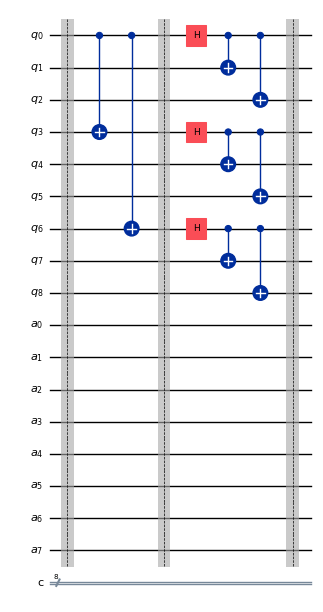

In [179]:
def encode_shor_code():
    """Create the 9-qubit Shor code circuit"""
    # Main registers
    qr = QuantumRegister(9, 'q')  # 9 data qubits
    anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, anc, cr)
    
    #Initialize input state
    # qc.h(0)

    qc.barrier()

    # First level encoding (phase flip code)
    qc.cx(0, 3)
    qc.cx(0, 6)
    
    qc.barrier()

    # Second level encoding (bit flip code)
    qc.h(0)  
    qc.h(3)
    qc.h(6)

    for i in [0, 3, 6]:
        qc.cx(i, i+1)
        qc.cx(i, i+2)
        
    qc.barrier() # Separate encoding from errors/measurement

    return qc

# Create and display circuit
shor_qc = encode_shor_code()
shor_qc.draw('mpl', scale=0.5)

In [180]:
def apply_random_errors_shor(qc, p_bit=0.1, p_phase=0.1):
    """Apply random bit and phase flip errors to the Shor code circuit
    
    Args:
        qc (QuantumCircuit): Circuit to apply errors to
        p_bit (float): Probability of bit flip on each qubit
        p_phase (float): Probability of phase flip on each qubit
    """
    for i in range(9):  # For each data qubit
        if np.random.random() < p_bit:
            qc.x(i)  # Bit flip
        if np.random.random() < p_phase:
            qc.z(i)  # Phase flip
    return qc


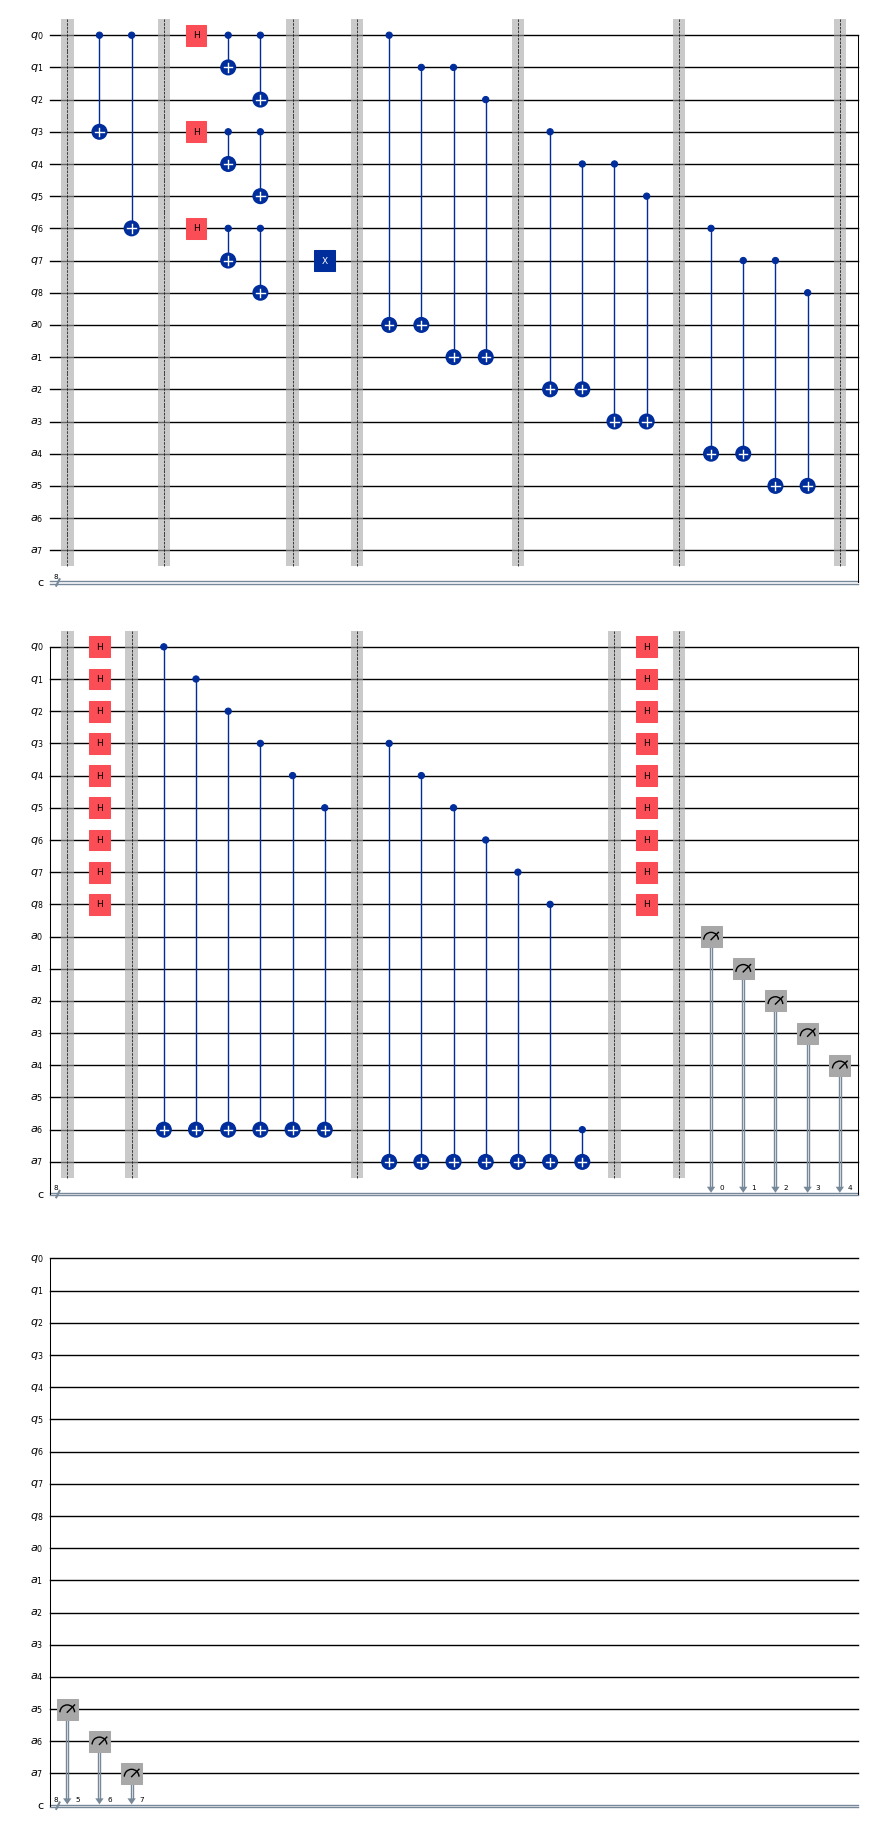

In [187]:
def shor_add_bit_syndrome_measurement(qc, anc):
    """Add Bit Flip syndrome measurement to Shor code"""

    # Bit flip Syndrome measurements
    for block in [0, 3, 6]:  # For each block of 3 qubits
        # ZZ measurement between first and second qubit
        qc.cx(block, anc[block//3*2])
        qc.cx(block+1, anc[block//3*2])

        # ZZ measurement between second and third qubit
        qc.cx(block+1, anc[block//3*2+1])
        qc.cx(block+2, anc[block//3*2+1])

        qc.barrier()
        
    qc.barrier()

    return qc

def shor_add_phase_syndrome_measurement(qc,anc):
    """Add Phase syndrome measurement to Shor code"""

    # Phase flip syndromes (between blocks)
    # (Convert Z errors to X errors)
    for qubit in range(0,9):
        qc.h(qubit)

    qc.barrier()

    # Compare first and second block
    qc.cx(0, anc[6])
    qc.cx(1, anc[6])
    qc.cx(2, anc[6])

    qc.cx(3, anc[6])
    qc.cx(4, anc[6])
    qc.cx(5, anc[6])
    
    qc.barrier()

    # Compare second and third block
    qc.cx(3, anc[7])  
    qc.cx(4, anc[7])  
    qc.cx(5, anc[7])  

    qc.cx(6, anc[7])
    qc.cx(7, anc[7])
    qc.cx(8, anc[7])
    
    qc.cx(anc[6], anc[7])

    qc.barrier()

    for qubit in range(0,9):
        qc.h(qubit)


    qc.barrier()

    return qc


def create_shor_code_with_syndromes(p_bit=0.1, p_phase=0.1):
    """Create the 9-qubit Shor code circuit with syndrome measurements"""
    # Main registers
    qr = QuantumRegister(9, 'q')  # 9 data qubits
    anc = QuantumRegister(8, 'a')  # 8 ancilla qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, anc, cr)
    
    qc = encode_shor_code()

    '''
    Add random errors
    '''
    qc = apply_random_errors_shor(qc, p_bit=p_bit, p_phase=p_phase)
    qc.barrier()
    
    '''Add Bit Flip Syndromes'''
    qc = shor_add_bit_syndrome_measurement(qc, anc)

    '''Add Phase Flip Syndromes'''
    qc = shor_add_phase_syndrome_measurement(qc,anc)

    '''Measure all ancilla to get syndromes'''
    qc.measure(anc, cr)
    
    return qc

qc = create_shor_code_with_syndromes(p_bit=0.10, p_phase=0.10)
qc.draw('mpl',scale=0.5)

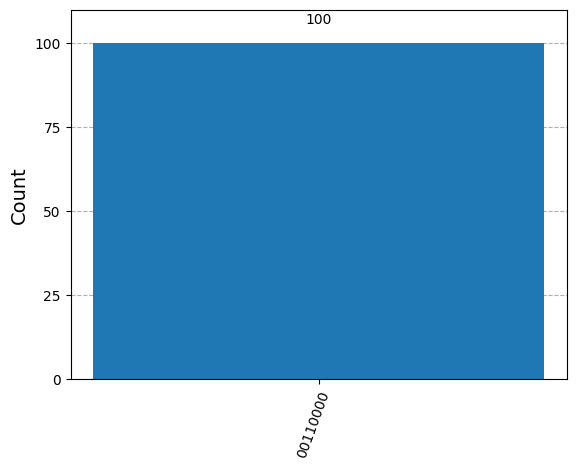

In [188]:
job = QasmSim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

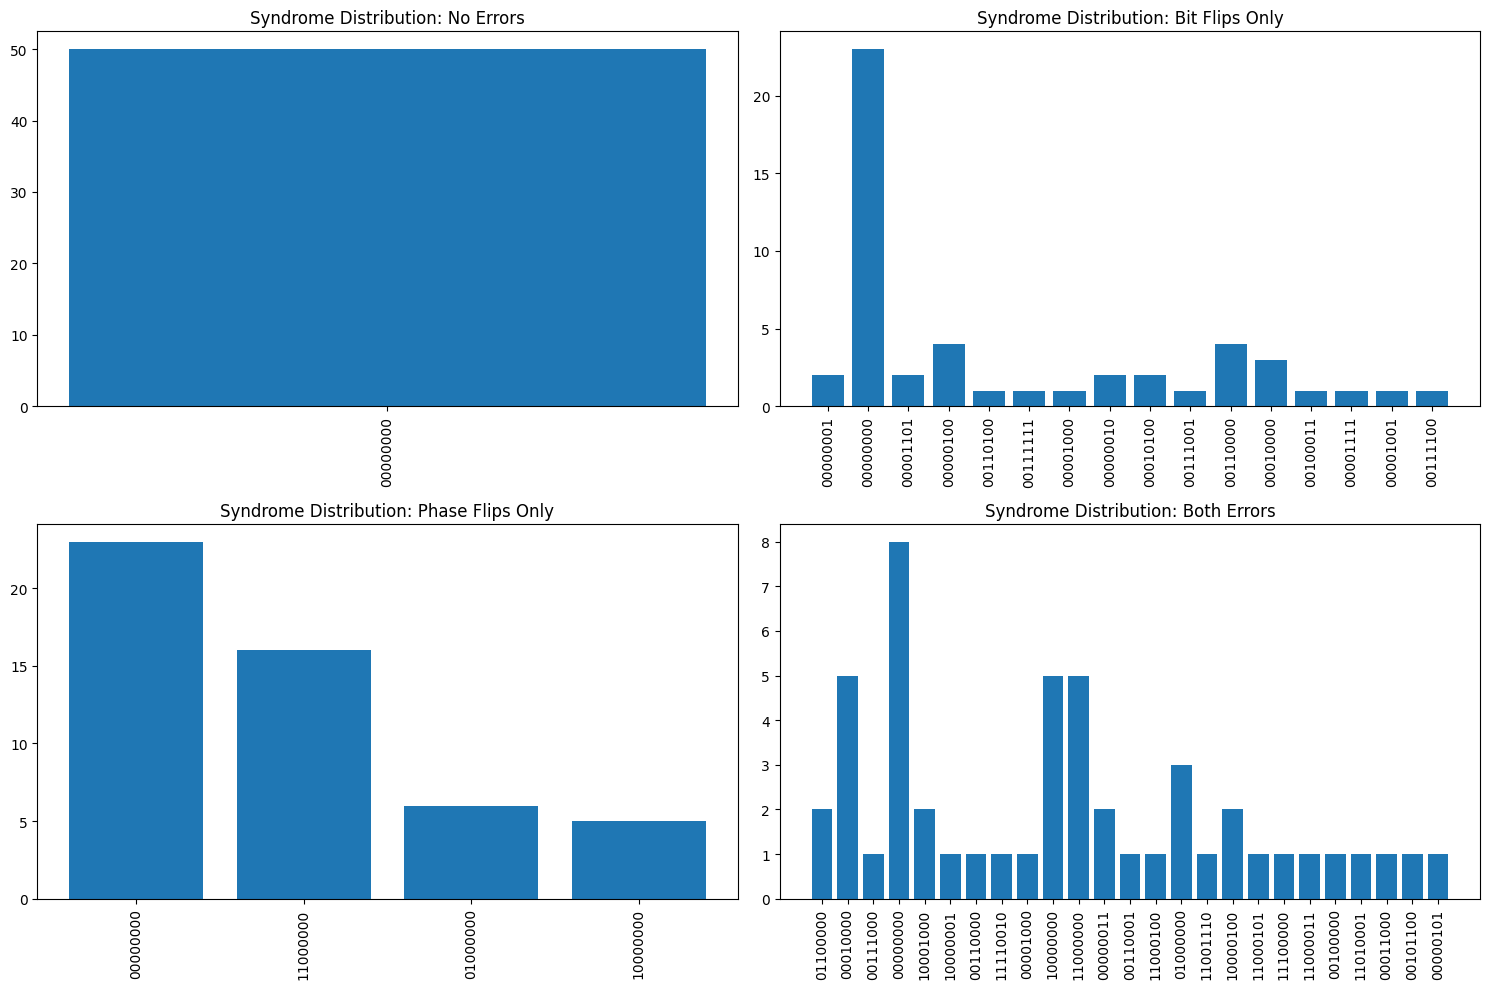

In [189]:
def run_shor_code_demo(initial_state=0, p_bit=0.1, p_phase=0.1, n_shots=1000):
    """Run full Shor code demonstration
    
    Args:
        initial_state (int): 0 or 1 for initial logical state
        p_bit (float): Bit flip error probability
        p_phase (float): Phase flip error probability
        n_shots (int): Number of circuit executions
    """
    # Create circuit
    qc = create_shor_code_with_syndromes(p_bit=p_bit, p_phase=p_phase)
        
    job = QasmSim.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()
    
    return counts


# Run demonstration with different error scenarios
scenarios = [
    (0.0, 0.0, "No Errors"),
    (0.1, 0.0, "Bit Flips Only"),
    (0.0, 0.1, "Phase Flips Only"),
    (0.1, 0.1, "Both Errors")
]

# Plot results for each scenario
plt.figure(figsize=(15, 10))
for i, (p_bit, p_phase, title) in enumerate(scenarios, 1):
    plt.subplot(2, 2, i)
    # counts = run_shor_code_demo(p_bit=p_bit, p_phase=p_phase)
    # plot_histogram(counts)

    counts = {}
    shots = arange(50)
    for shot in shots: 
        counts = combine_counts(counts, run_shor_code_demo(p_bit=p_bit, p_phase=p_phase))
    # plot_histogram(counts)
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=90)

    plt.title(f"Syndrome Distribution: {title}")

plt.tight_layout()
plt.show()


## Analysis Questions

1. How does the error correction threshold change with the number of qubits?
2. What are the trade-offs between different error correction codes?
3. Why can't we just measure the qubits directly to detect errors?
4. How would you implement error correction in a real quantum computer?

## Additional Challenges

1. Implement the Steane 7-qubit code
2. Compare the performance of different codes under various error models
3. Design a circuit to measure the fidelity of the error correction

## References

1. [Quantum Error Correction for Beginners](https://arxiv.org/abs/0905.2794)
2. [Surface Codes: Towards Practical Large-Scale Quantum Computation](https://arxiv.org/abs/1208.0928)
3. Nielsen & Chuang, Chapter 10: Quantum Error Correction